In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [8]:
%pip install "tensorflow==2.16.1"

Note: you may need to restart the kernel to use updated packages.


In [9]:
from tensorflow import keras

In [10]:
p_train = r"../data/manipulated_data_set/test_data.csv"
p_test  = r"../data/manipulated_data_set/train_data.csv"
train = pd.read_csv(p_train)
test  = pd.read_csv(p_test)

In [11]:
target = 'NSP' if 'NSP' in train.columns else 'CLASS'

In [12]:
y_train = train[target].to_numpy(dtype=int)
X_train = train.loc[:, train.columns != target].to_numpy(dtype='float32')

y_test  = test[target].to_numpy(dtype=int)
X_test  = test.loc[:,  test.columns  != target].to_numpy(dtype='float32')

In [13]:
y_train = y_train - 1
y_test  = y_test  - 1

In [14]:
vals, cnts = np.unique(y_train, return_counts=True)
class_weight = {int(v): float(cnts.max()/c) for v,c in zip(vals, cnts)}
print("class_weight:", class_weight)

class_weight: {0: 1.0, 1: 5.974226804123711, 2: 8.585185185185185}


In [15]:
num_classes = int(np.unique(y_train).size)
print("num_classes =", num_classes, " labels in train:", np.unique(y_train))

num_classes = 3  labels in train: [0 1 2]


In [16]:
inputs = keras.Input(shape=(X_train.shape[1],))
x = keras.layers.BatchNormalization()(inputs)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [17]:
es = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=10, restore_best_weights=True
)
hist = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200, batch_size=32,
    class_weight=class_weight,
    callbacks=[es], verbose=1
)


Epoch 1/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6613 - loss: 1.8706 - val_accuracy: 0.1040 - val_loss: 6.9858
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8714 - loss: 1.2486 - val_accuracy: 0.1074 - val_loss: 4.4218
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8723 - loss: 1.0064 - val_accuracy: 0.1879 - val_loss: 2.5711
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8975 - loss: 0.8945 - val_accuracy: 0.3658 - val_loss: 1.6358
Epoch 5/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9126 - loss: 0.8437 - val_accuracy: 0.6678 - val_loss: 0.7832
Epoch 6/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9160 - loss: 0.7852 - val_accuracy: 0.7349 - val_loss: 0.6691
Epoch 7/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9101 - loss: 0.8175 - val_accuracy: 0.8691 - val_loss: 0.3214
Epoch 8/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9076 - loss: 0.8247 - val_accuracy: 0.8725 - v

In [40]:
proba = model.predict(X_test)
pred = proba.argmax(axis=1)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred, digits=2))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
Accuracy: 0.9373040752351097
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       496
           1       0.92      0.76      0.83       101
           2       0.58      0.95      0.72        41

    accuracy                           0.94       638
   macro avg       0.83      0.90      0.85       638
weighted avg       0.95      0.94      0.94       638

Confusion matrix:
 [[482   6   8]
 [  4  77  20]
 [  1   1  39]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


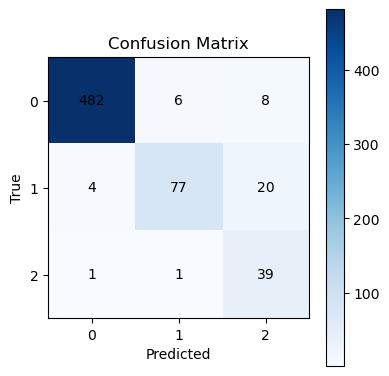

In [42]:
pred = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix'); plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes)); plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted'); plt.ylabel('True')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.tight_layout(); plt.show()

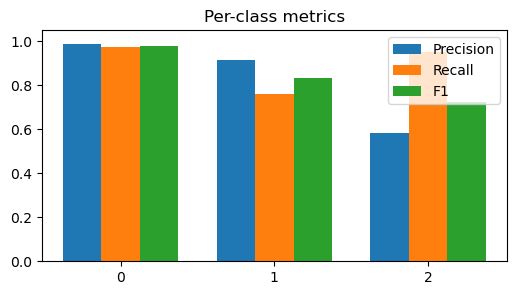

In [44]:
from sklearn.metrics import precision_recall_fscore_support
p, r, f1, _ = precision_recall_fscore_support(y_test, pred, labels=range(num_classes), zero_division=0)
x = np.arange(num_classes)

plt.figure(figsize=(6,3))
width = 0.25
plt.bar(x - width, p, width, label='Precision')
plt.bar(x,         r, width, label='Recall')
plt.bar(x + width, f1, width, label='F1')
plt.xticks(x, range(num_classes)); plt.ylim(0,1.05)
plt.legend(); plt.title('Per-class metrics'); plt.show()